# Graph Neural Networks Applications

Background: Graph Representation Learning

- Given one or more input graphs, we use a (deep) encoder to map nodes to high-dimensional embedding space

- Objectives:
  - Node property prediction
  - Link/edge property prediction
  - Graph/subgraph prediction

Application:

- Social Networks: recommender system

- Natural Science: physical simulation

- Medicine: drug side-effects, molecule generation

- Explainability of GNNs

# PinSage: Web-scale Recommender System

## background

Pinterest (like Little Red Book)

- a social media platform that allows users to find, save, and share ideas, images, and videos in the form of "pins" organized into "boards" in the domain of fashion, home decor, DIY projects, recipes, travel, and more. 

- Pinterest makes a profit through advertising.

- Pin (item): A visual bookmark. 
    
    - user can save content from internet as a pin to a board. 
    
    - merchants can create pins to promote products or services. These pins appear in users' feeds and search results, just like regular pins, but are labeled as "Promoted" to indicate that they are sponsored content.

- Board (user): A collection of common pins. a user can create multiple boards.

Pinterest is a Graph

- one Graph: 3B nodes (users, 2B pins, 1B boards), 20B edges (user-item interactions: View, purchase, review, follow, likes)

- Graph is dynamic: Need to apply to new nodes without model retraining

- Graph is large-scale: billion nodes and edges

- Rich node features: text, images, video, connectivity

PinSage

- task: link prediction

- a Graph Convolutional Neural Network (GCN) used by Pinterest for generating pin embeddings and board embeddings to make personalized recommendations.

- Items embeddings must be able to capture text feature, image feature and graph structure, are essential to various downstream tasks like recommendation of Pins, classification, clustering, ranking.

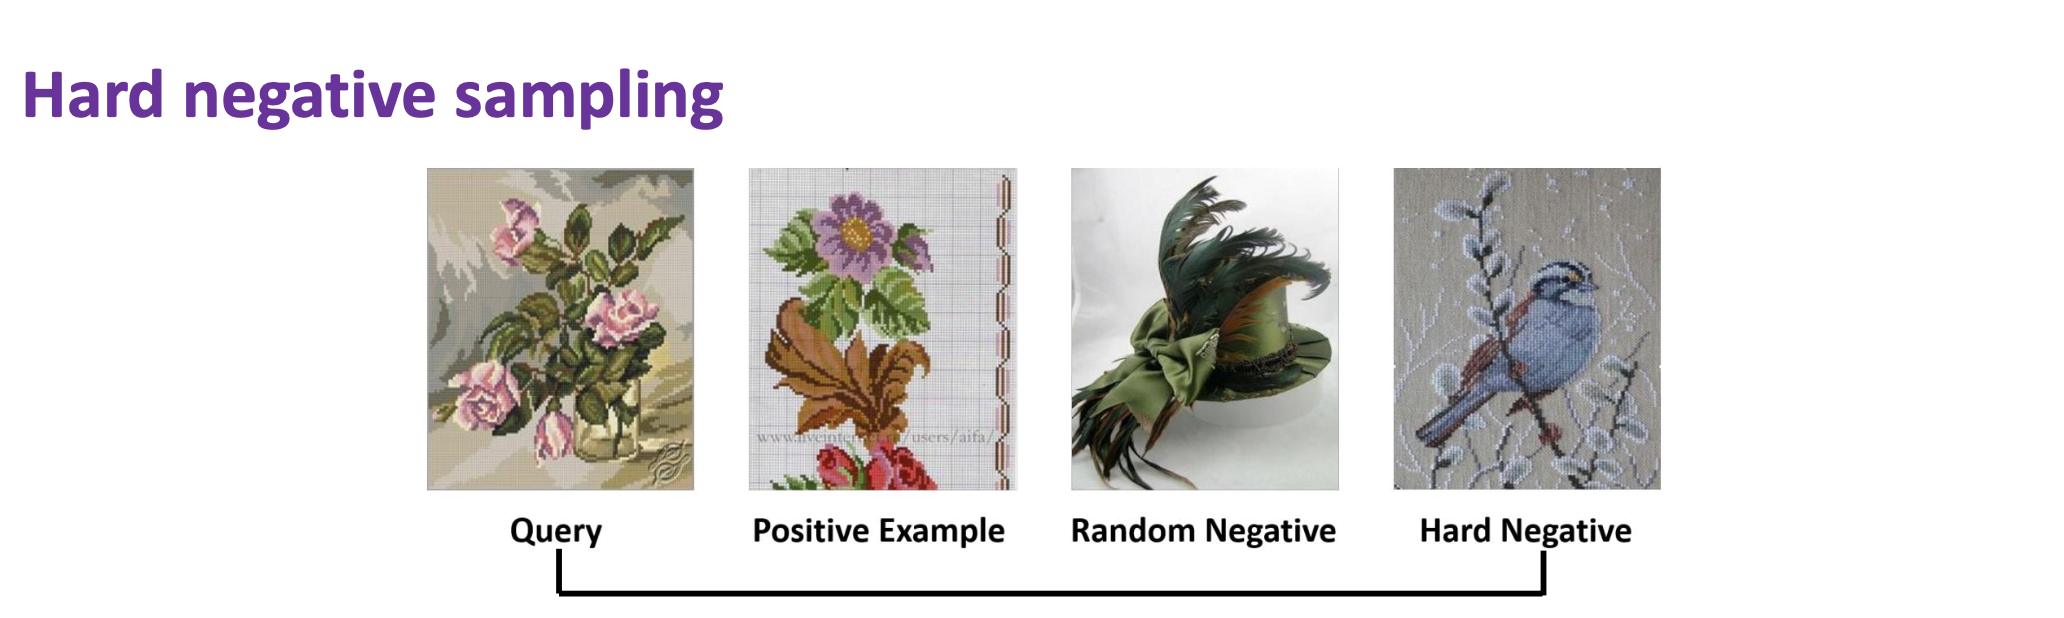

## algorithm

1. collect data $\mathcal{D}$: 

    Collect billions of training pairs from logs: 

    A positive pair $(u, v)$: a pin and a board that contains it, 
    
    A negative pair $(u, n)$: a hard negative pin and a board, sampled by personalized PageRank (PPR). Curriculum training on hard negatives: provide harder and harder examples over time.

2. Construct a graph: 

    nodes: pins, boards
    
    edges: representing various relationships between pins, such as sharing the same board or having similar content.


3. Train GCN: 

    generate similar embeddings for positive pairs

    generate dissimilar embeddings for negative pairs

    objective: Max-margin loss $L = \sum_{(u, v) \in \mathcal{D}} \max(0, m + z_u^Tz_v - z_u^Tz_n)$

    where $m$ is the margin (a hyperparameter), how much positive pair similarity will differ from negative pair

    similarity is inner product of pin embedding and board embedding for training simplicity
    
    - $z_u^Tz_v$ is similarity score between positive pair
    - $z_u^Tz_n$ is similarity score between negative pair

    importance pooling: sample a fixed-size set of importance-based neighbors by simulating random walks and selecting neighbors with the highest Personalized PageRank

4. Inference via MapReduce: 

    MapReduce: Decompose each aggregation step across all nodes into three operations in MapReduce, i.e., map, join, and reduce. Avoid repeated computation

    Generate embeddings for all pins and all boards in the graph using the trained PinSage model. 
    
    These embeddings capture the semantic relationships and similarities between pins.


5. Nearest neighbor search: 

    - Query: which item to recommend to the board with embedding $u$?

    - Answer: find the closest item embedding $v$ by nearest neighbor.

6. evaluation

    - Baselines: image: VGG, text: word2vec, graph: Pixie

    - PinSage gives 150% improvement in hit rate and 60% improvement in MRR over the best baseline

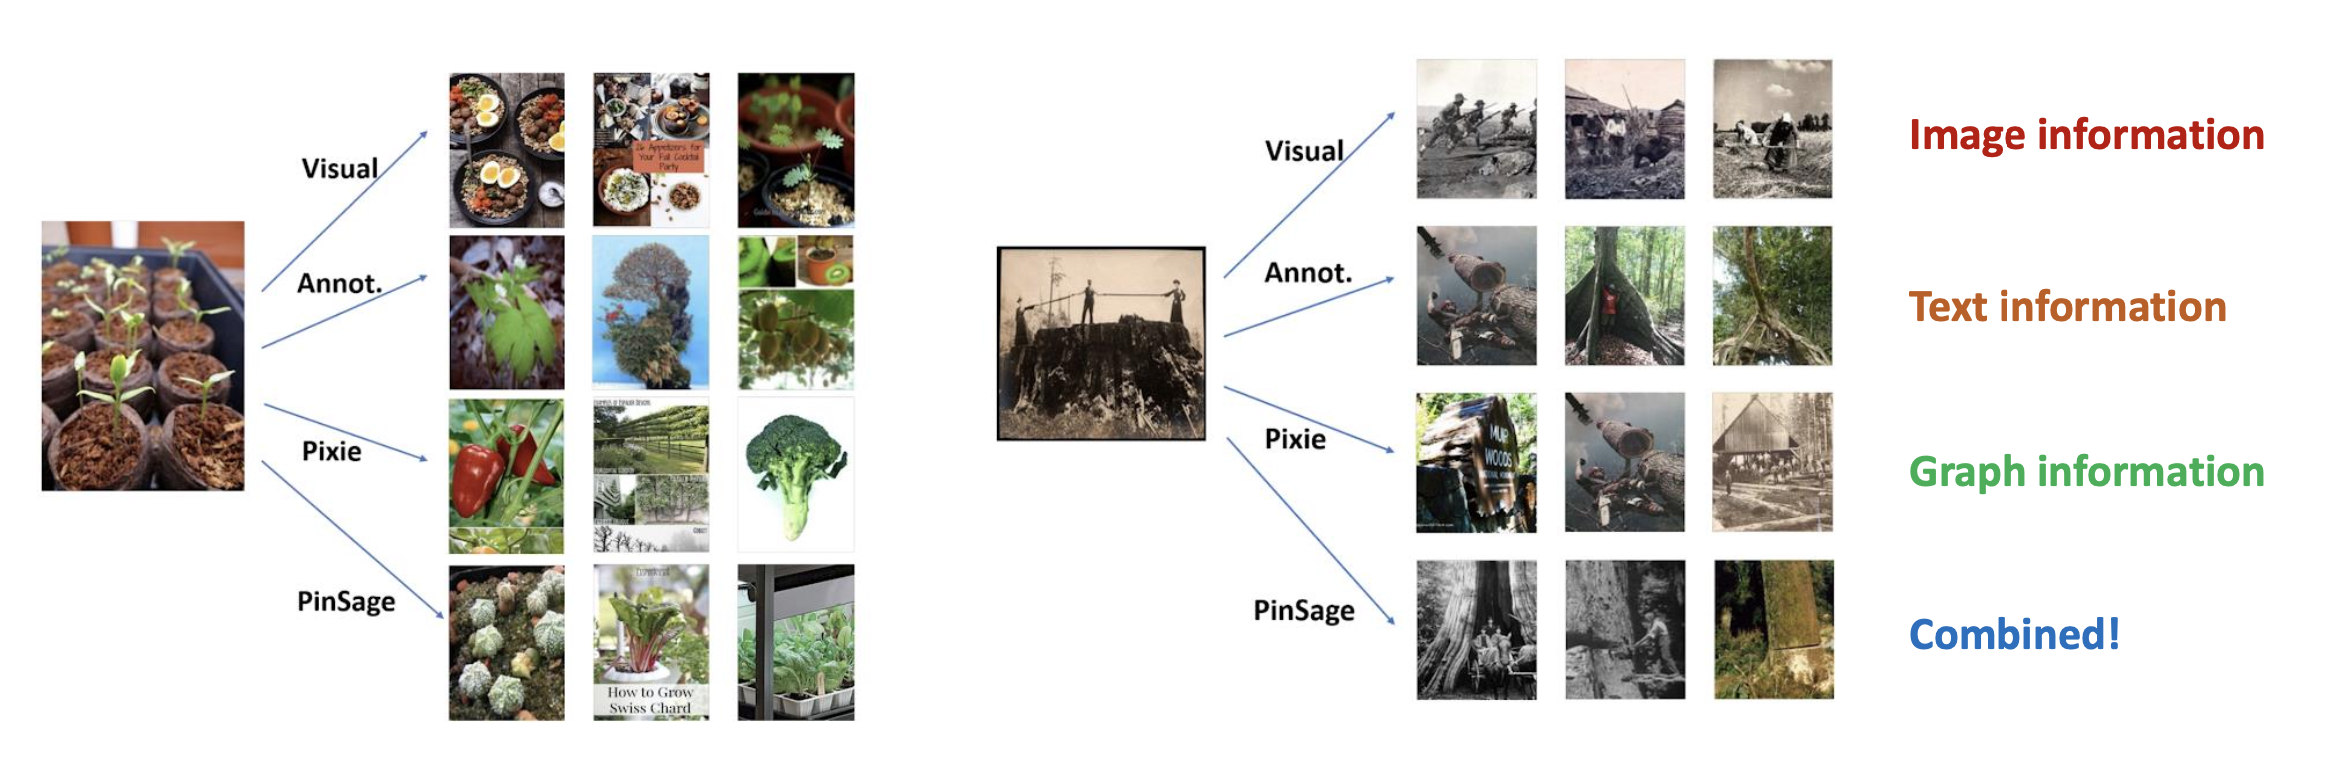

# Simulations in Science and Engineering

## Why Learning Simulation

- Engineered simulators:
  - Substantial effort to build
  - Substantial resources to run
  - Only as accurate as the designer
  - Not always suitable for solving inverse problems


- Learned simulators:
  - physical system is a graph: nodes (particles) and edges (interactions between particles).
  - Shared architectures
  - Can be directly optimized for efficiency
  - Can be as accurate as the available data
  - Gradient-based search for control

## Graph Network Simulator (GNS)

### architecture

3 networks:

Encoder

- Node input features: position, previous 5 velocities, particle type

- Edge input features: displacements
  - Embed features with MLP

- Construct KNN graph

Processor
- Message-passing layers (x10) on kNN graph
  - Concatenate node and edge features, and compute message function through MLP
  - Outputs embeddings for each particle: Used to predict next step dynamics

Decoder
- Decode acceleration
- Feed into Euler integrator to obtain position and velocity
- Sum over L2 Loss for all particles in each pair

### training and inference

Training: One-step minibatch training

- training pair $(t_i, t_{i+1})$: Historical particle states at consecutive, Equal-interval, and discrete time steps

- add Gaussian noise to prevent error accumulation at evaluation

inference: 1000s of steps

- input: initial condition $t_0$

- output: predictions of the evolution of the system over time $t_1, ..., t_n$

# medicine

## Polypharmacy Side Effects: GCN

Modeling Polypharmacy Side Effects with Graph Convolutional Networks, Bioinformatics 2018

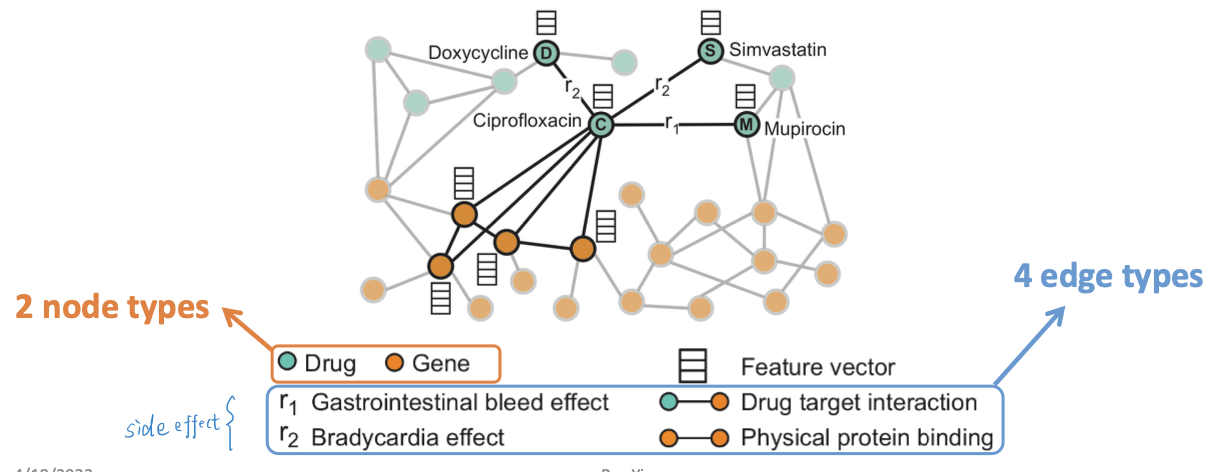

drug-gene interaction is a Heterogeneous (multimodal) graphs

- graphs with different node types (drug or gene) and/or edge types (e.g., Gastrointestinal bleed effect, drug target interaction, Bradycardia effect, physical protein binding)

- Systematic experimental screening of drug interactions is challenging

- use GNN to model polypharmacy side effect is more efficient


task: link prediction

- predict the likelihood that an edge $(c, r_2, s)$ exists between drug nodes c and s

- Meaning: Drug combination $(c, s)$ leads to polypharmacy side effect $r_2$

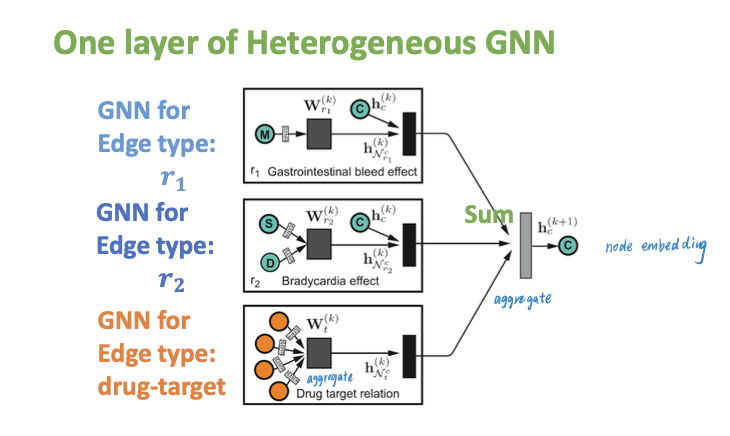

### algorithm


training

- input: a heterogeneous graph

- each layer of GNN: Compute messages from each edge type, then aggregate across different edge types to obtain node embedding

- output: node embeddings

Inference

- input: node embeddings of query drug pairs

- output: predicted edges

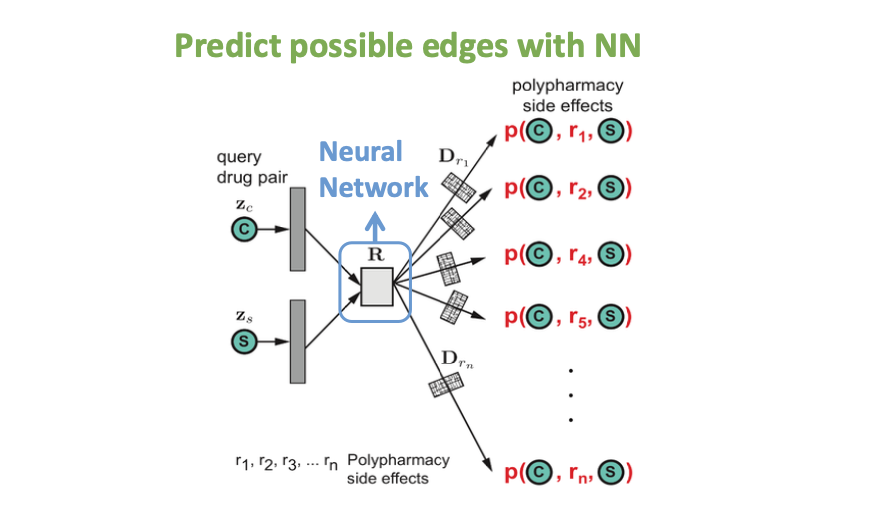

## Drug discovery: Graph Convolutional Policy Network

Graph Convolutional Policy Network for Goal-Directed Molecular Graph Generation, NeurIPS 2018.

- GCPN can generate molecules with high specified property score.

- GCPN can also edit a given molecule for a few steps to achieve higher property score.

### task: Goal-Directed graph generation 

- High scores 
  - Optimize a given objective: e.g., drug-likeness
  - hard: Only available at the end of generation

- Valid 
  - Obey underlying rules (Valid): e.g., chemical validity rules
  - hard: Often not differentiable

- Realistic 
  - Are learned from examples: Imitating a molecule graph dataset
  - hard: Requires the model to learn the distribution of graph structures

Idea: Reinforcement Learning

- An ML agent observes the environment, takes an action to interact with the environment, and receives positive or negative reward

- The agent then learns from this loop

- Key idea: Agent can directly learn from environment, which is a
blackbox to the agent


### Key components

GCPN combines graph representation and reinforcement learning.

- GCN: captures graph structural information.

- Reinforcement learning: guides generation towards desired objectives.

- Supervised learning: imitates examples in given datasets.

### algorithm

- Insert nodes

- Use GNN to predict which nodes to connect

- Take action (check chemical validity)

- Compute reward = Final reward + Step reward

    - Step reward: Generation is step-by-step, with additional edges and nodes generated at each step. Assign small positive reward for valid action at each step (satisfy valency rules).

    - Final reward: Delayed reward with final metric (drug-likeness) obtained at the end of the generation process.Assign positive reward for high desired property at the end.

# Explainability of GNNs

GNNExplainer: Generating Explanations for Graph Neural Networks, NeurIPS 2019

GNNEXPLAINER provides interpretable explanations for predictions made by any GNN model on any graph-based  task. 

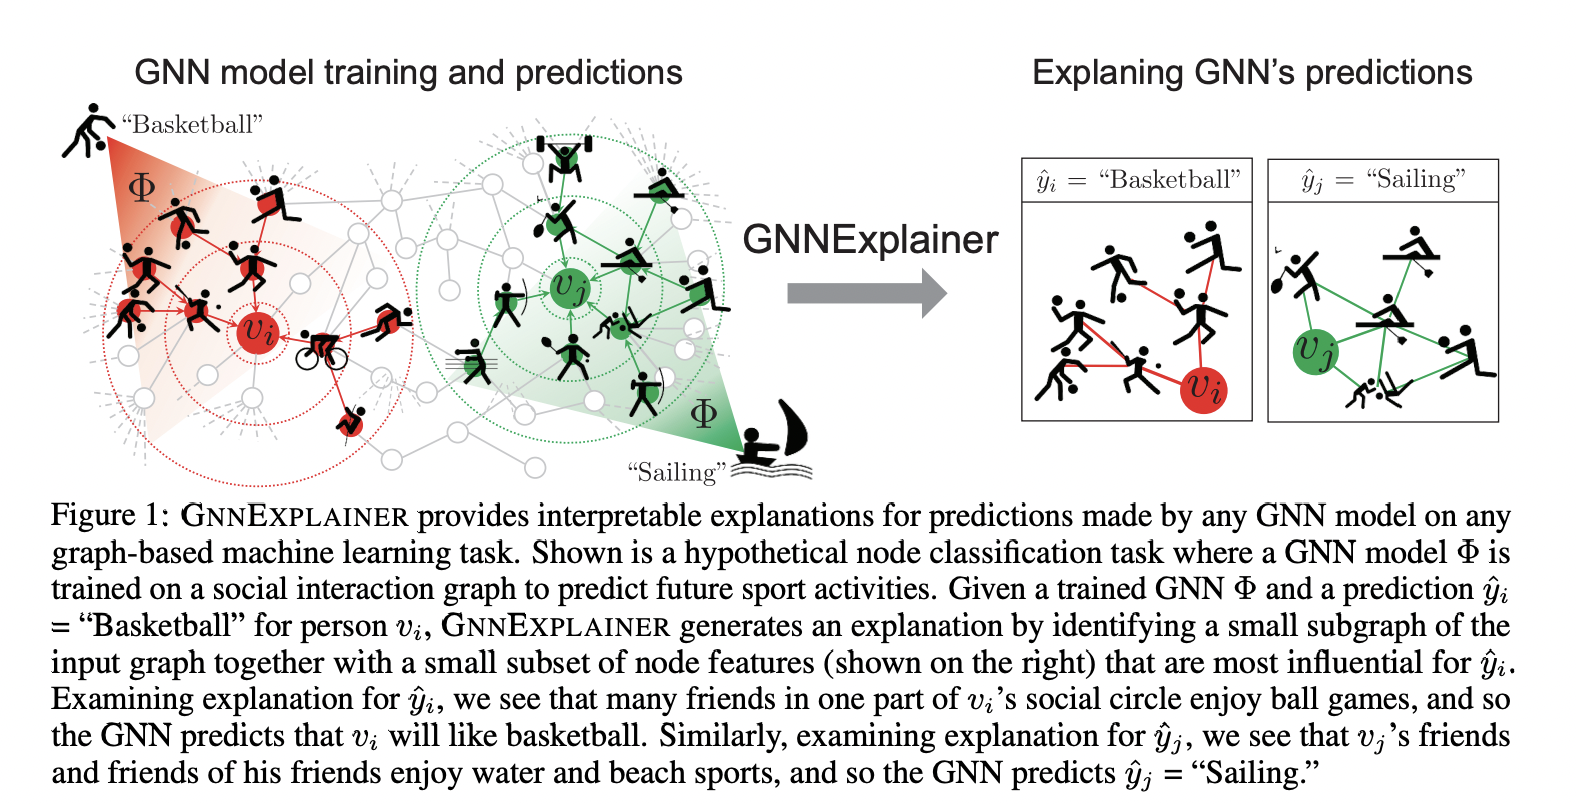

explain predictions for multiple tasks

- Explain link prediction: Why is an item recommended to a user? 

- Explain graph classification: Why is the molecule mutagenic?

- Explain node classification: Why is the user classified as fraudulent?

model agnostic (post-hoc)

- can be applied to all models: e.g., GCN, GraphSAGE, GAT

## objective

objective: maximize mutual information between true label $Y$ and explanation $(G_S, X_S)$, where $H$ is entropy.

$$
\max_{G_S} MI(Y, (G_S, X_S)) = H(Y) - H(Y | G = G_S, X = X_S)
$$


input: graph $G_c$ and node feature $X_c$

output: subgraph $G_s$ and node features $X_s^F$

$F$ is mask masks out unimportant dimensions

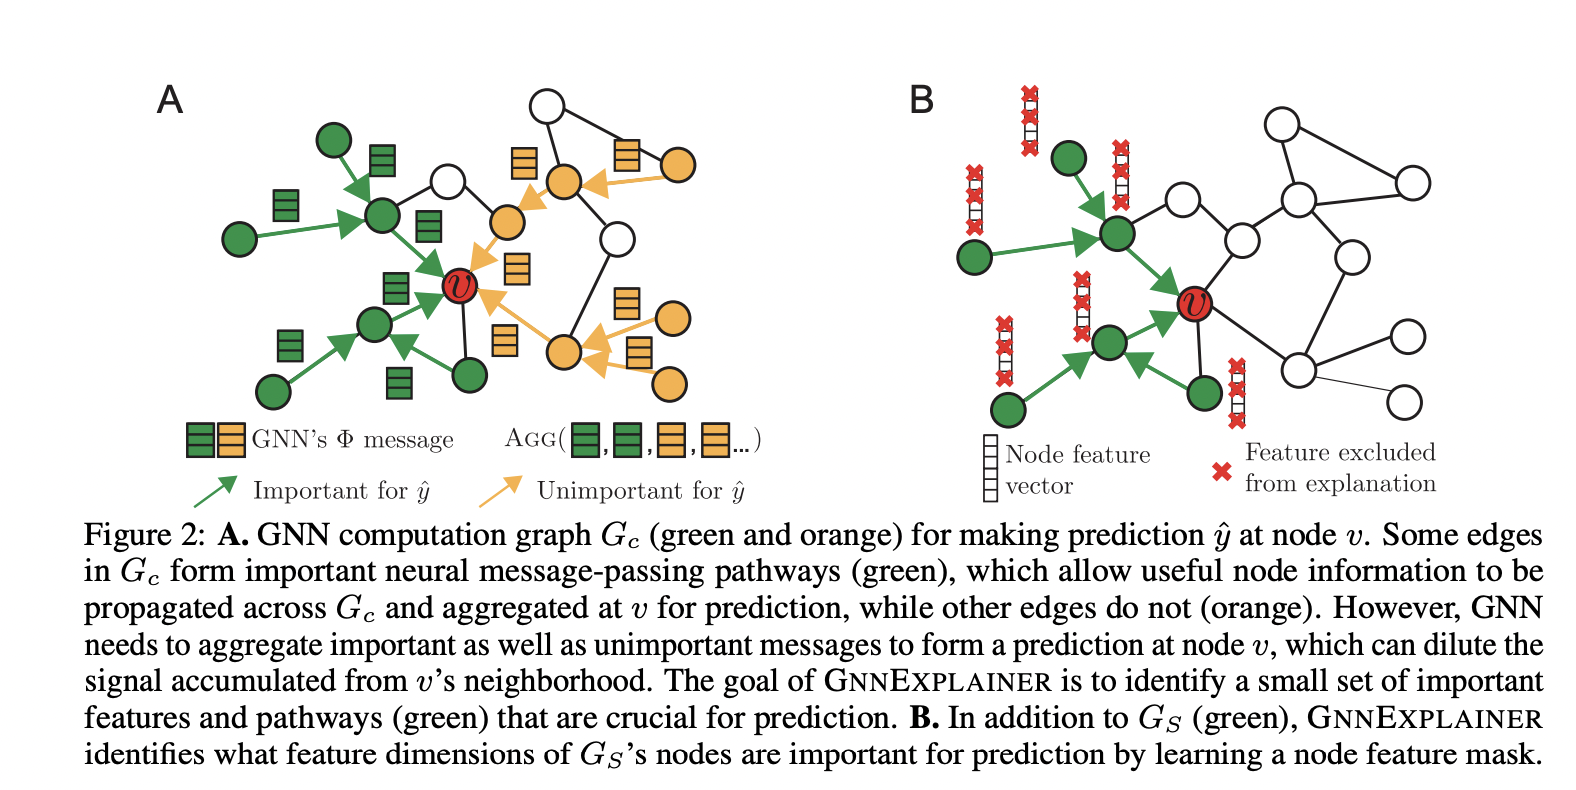